# From Words to Attention: A Minimal NumPy Implementation

In this notebook we will build a very small example of **self attention** using only NumPy.

The main goal is **intuition**. We want to understand:
- What problem attention is trying to solve
- How a sentence becomes numbers
- How queries (Q), keys (K) and values (V) are computed
- How the attention weights are formed and applied

We will start with a simple sentence and go step by step from:
natural language → tokens → vectors → matrices → attention scores.

---

## 0. What problem does attention solve?

Consider the sentence:

> "The cat sat on the mat because it was tired"

If we want to understand what "it" refers to, we need to look back at the earlier words.
Traditional sequence models sometimes struggle with long range dependencies.
Self attention offers a simple idea:

> When processing a word, allow it to **directly look at all other words** in the sentence and decide how much to focus on each one.

The result of this "looking" is a set of **attention weights** that tell us how much each word contributes to the new representation of the current word.


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3, suppress=True)

def softmax(x):
    """
    Compute softmax over the last axis of x in a numerically stable way.
    """
    x = np.array(x)
    x_max = np.max(x, axis=-1, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=-1, keepdims=True)


## 1. A simple sentence and tokenization

We start with a short sentence:

> "The cat sat on the mat"

We will:
- Split it into tokens
- Later assign each token an id and a vector

This is a very simplified tokenization step.
Real models often use more advanced tokenizers (subword units, punctuation handling, lowercasing and so on).


In [4]:
sentence = "The cat sat on the mat"

tokens = sentence.split()
tokens


['The', 'cat', 'sat', 'on', 'the', 'mat']

It is useful to see the sentence decomposed into tokens, with their positions.


In [5]:
# Build a tiny table with positions and tokens
positions = list(range(len(tokens)))

token_table = pd.DataFrame({
    "position": positions,
    "token": tokens
})

token_table


,position,token
0,0,The
1,1,cat
2,2,sat
3,3,on
4,4,the
5,5,mat


## 2. Vocabulary and token ids

Next we build a tiny vocabulary that maps each unique token to a unique index.
Then we map each token in the sentence to its integer id.


In [6]:
# Build vocabulary: each distinct token gets an index
vocab = {token: idx for idx, token in enumerate(sorted(set(tokens)))}
vocab

{'The': 0, 'cat': 1, 'mat': 2, 'on': 3, 'sat': 4, 'the': 5}

In [7]:
# Map tokens in the sentence to ids
token_ids = [vocab[token] for token in tokens]

pd.DataFrame({
    "position": positions,
    "token": tokens,
    "token_id": token_ids
})


,position,token,token_id
0,0,The,0
1,1,cat,1
2,2,sat,4
3,3,on,3
4,4,the,5
5,5,mat,2


## 3. From tokens to embeddings

Neural networks do not work directly on text.
They work on numbers, usually vectors.

For each token id we will create a small embedding vector.
In real models:
- Vocabulary size can be in the tens or hundreds of thousands
- Embedding dimension can be 128, 512, 768, or even larger

Here we use:
- `V` = number of unique tokens in our tiny vocabulary
- `d_model = 4` as embedding dimension

In [8]:
V = len(vocab)
d_model = 4

np.random.seed(0)  # For reproducibility

# Embedding matrix: shape (V, d_model)
E = np.random.randn(V, d_model)

E

array([[ 1.764,  0.4  ,  0.979,  2.241],
       [ 1.868, -0.977,  0.95 , -0.151],
       [-0.103,  0.411,  0.144,  1.454],
       [ 0.761,  0.122,  0.444,  0.334],
       [ 1.494, -0.205,  0.313, -0.854],
       [-2.553,  0.654,  0.864, -0.742]])

In [9]:
# Get embeddings for our sentence tokens
# Shape: (sequence_length, d_model)
X = np.array([E[idx] for idx in token_ids])

X.shape, X


((6, 4),
 array([[ 1.764,  0.4  ,  0.979,  2.241],
        [ 1.868, -0.977,  0.95 , -0.151],
        [ 1.494, -0.205,  0.313, -0.854],
        [ 0.761,  0.122,  0.444,  0.334],
        [-2.553,  0.654,  0.864, -0.742],
        [-0.103,  0.411,  0.144,  1.454]]))

## 4. Queries, keys and values

Self attention uses three different linear projections of the embeddings:

- **Query (Q)**: what this token is asking for
- **Key (K)**: a sort of address or signature of this token
- **Value (V)**: the actual content that can be passed to the next layer

For each token embedding `x` (a row in `X`) we compute:

- `q = x @ W_Q`
- `k = x @ W_K`
- `v = x @ W_V`

where `W_Q`, `W_K`, `W_V` are trainable weight matrices.

We choose:

- `d_model = 4` as before
- `d_k = 4` for the dimension of queries and keys
- `d_v = 4` for the dimension of values


In [10]:
d_k = 4
d_v = 4

# Weight matrices: shape (d_model, d_k) or (d_model, d_v)
W_Q = np.random.randn(d_model, d_k)
W_K = np.random.randn(d_model, d_k)
W_V = np.random.randn(d_model, d_v)

W_Q.shape, W_K.shape, W_V.shape


((4, 4), (4, 4), (4, 4))

In [11]:
# Compute Q, K, V for all tokens in the sentence
# Shapes: (seq_len, d_k) and (seq_len, d_v)
Q = X @ W_Q
K = X @ W_K
V = X @ W_V

Q.shape, K.shape, V.shape


((6, 4), (6, 4), (6, 4))

## 5. A tiny numeric example by hand

Before we apply attention to our real sentence, let us build a toy example with very small numbers.

Imagine we have just two tokens, A and B, and we define:

\[
Q = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix},
\quad
K = \begin{bmatrix}
1 & 0 \\
0 & 1
\end{bmatrix},
\quad
V = \begin{bmatrix}
1 & 2 \\
3 & 4
\end{bmatrix}
\]

Here:
- The query and key vectors are one hot like vectors
- The value vectors store some simple information

We will compute:

1. The score matrix \( S = Q K^\top \)
2. The scaled scores \( S / \sqrt{d_k} \)
3. The row wise softmax of the scaled scores
4. The final output \( \text{softmax}(S / \sqrt{d_k}) V \)

Since `Q` and `K` are identity like, we expect each token to attend mostly to itself.


In [12]:
Q_toy = np.array([[1.0, 0.0],
                  [0.0, 1.0]])

K_toy = np.array([[1.0, 0.0],
                  [0.0, 1.0]])

V_toy = np.array([[1.0, 2.0],
                  [3.0, 4.0]])

d_k_toy = 2

Q_toy, K_toy, V_toy


(array([[1., 0.],
        [0., 1.]]),
 array([[1., 0.],
        [0., 1.]]),
 array([[1., 2.],
        [3., 4.]]))

In [13]:
# 1. Scores
scores_toy = Q_toy @ K_toy.T
scores_toy


array([[1., 0.],
       [0., 1.]])

In [14]:
# 2. Scale by sqrt(d_k)
scaled_scores_toy = scores_toy / np.sqrt(d_k_toy)
scaled_scores_toy


array([[0.707, 0.   ],
       [0.   , 0.707]])

In [15]:
# 3. Softmax row wise
attn_weights_toy = softmax(scaled_scores_toy)
attn_weights_toy

array([[0.67, 0.33],
       [0.33, 0.67]])

In [16]:
# 4. Output
output_toy = attn_weights_toy @ V_toy
output_toy

array([[1.66, 2.66],
       [2.34, 3.34]])

Interpretation:

- The attention weights are close to an identity matrix.
- Each token mostly attends to itself, which is what we expected, given Q and K.

This small example shows the full pipeline of attention on matrices that are easy to understand by hand.
Now we will apply the same logic to our real sentence.


## 6. Attention for a single word

Let us pick one token to focus on.
We will choose the token `"cat"` and see how it attends to all tokens in the sentence.

Steps:

1. Extract the query vector `q_cat` for `"cat"`.
2. Compute a similarity score with every key vector in `K`.
3. Scale the scores by `sqrt(d_k)` (for numerical stability).
4. Apply softmax to get attention weights that sum to 1.
5. Use the weights to compute a weighted sum of the value vectors `V`.

This gives a new context aware representation for the token `"cat"`.


In [17]:
tokens


['The', 'cat', 'sat', 'on', 'the', 'mat']

In [18]:
# Find the index of "cat" in the sequence
cat_pos = tokens.index("cat")
cat_pos


1

In [19]:
# 1. Query vector for "cat"
q_cat = Q[cat_pos]  # shape (d_k,)
q_cat


array([ 1.711, -6.216, -0.338, -0.525])

In [20]:
# 2. Similarity scores between q_cat and ALL keys K
# scores[i] = q_cat dot K[i]
scores = q_cat @ K.T  # shape (seq_len,)
scores


array([ 25.056,   8.256,   3.699,   6.729, -21.388,   8.982])

In [21]:
# 3. Scale by sqrt(d_k)
scale = np.sqrt(d_k)
scaled_scores = scores / scale
scaled_scores


array([ 12.528,   4.128,   1.849,   3.365, -10.694,   4.491])

In [22]:
# 4. Softmax to get attention weights
attn_weights_cat = softmax(scaled_scores)
attn_weights_cat


array([0.999, 0.   , 0.   , 0.   , 0.   , 0.   ])

In [23]:
# Check that weights sum to 1
attn_weights_cat.sum()


1.0

In [24]:
# 5. Weighted sum of value vectors
# new_rep_cat = sum_i (attn_weights_cat[i] * V[i])
new_rep_cat = attn_weights_cat @ V  # shape (d_v,)
new_rep_cat


array([-2.01 ,  0.113, -1.406, -0.588])

Let us inspect the attention weights for `"cat"` together with the tokens.


In [25]:
for token, w in zip(tokens, attn_weights_cat):
    print(f"{token:>5}: {w:.3f}")


  The: 0.999
  cat: 0.000
  sat: 0.000
   on: 0.000
  the: 0.000
  mat: 0.000


Interpretation:

Right now the weights come from random parameters, so the pattern is arbitrary.
In a trained model we would expect:

- The token `"cat"` to assign higher weights to tokens that are relevant to it
  for example verbs like `"sat"` or nearby context such as `"the"` and `"mat"`,
  depending on the training objective.
- Tokens that have less semantic or syntactic connection would receive lower weights.

Even with random weights, this example shows how a single token can mix information
from the entire sentence through a weighted sum of the value vectors.


## 7. Attention for all tokens with matrices

So far we computed attention only for the token `"cat"`.

Now we will compute self attention for the whole sequence in one shot using matrix operations.

The general formula for **scaled dot product attention** is:

\[
\text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
\]

Where:

- `Q` has shape `(seq_len, d_k)`
- `K` has shape `(seq_len, d_k)`
- `V` has shape `(seq_len, d_v)`
- The result has shape `(seq_len, d_v)`

Each row of the output is the new, context aware representation of one token.


In [26]:
# 1. Compute raw scores matrix: shape (seq_len, seq_len)
scores_matrix = Q @ K.T  # row i contains scores of token i against all tokens j

# 2. Scale by sqrt(d_k)
scaled_scores_matrix = scores_matrix / np.sqrt(d_k)

scaled_scores_matrix.shape


(6, 6)

In [27]:
# 3. Apply softmax row wise to get attention weights
attn_weights = softmax(scaled_scores_matrix)

attn_weights.shape


(6, 6)

In [28]:
# 4. Output of the attention layer
# Shape: (seq_len, d_v)
attn_output = attn_weights @ V

attn_output.shape


(6, 4)

In [29]:
attn_output


array([[ 0.197, -1.37 , -0.848,  0.094],
       [-2.01 ,  0.113, -1.406, -0.588],
       [-1.961,  0.11 , -1.371, -0.567],
       [-0.648, -0.009, -0.765, -0.172],
       [-1.932,  0.123, -1.422, -0.539],
       [ 0.217, -1.392, -0.863,  0.102]])

We can verify that the row corresponding to `"cat"` in `attn_output` is the same
as `new_rep_cat` computed manually above, up to small numerical differences.


In [30]:
attn_output_cat = attn_output[cat_pos]

print("Manual new_rep_cat:     ", new_rep_cat)
print("Matrix attn_output_cat: ", attn_output_cat)
print("Difference (L2 norm):   ", np.linalg.norm(new_rep_cat - attn_output_cat))


Manual new_rep_cat:      [-2.01   0.113 -1.406 -0.588]
Matrix attn_output_cat:  [-2.01   0.113 -1.406 -0.588]
Difference (L2 norm):    0.0


## 8. Visualizing attention weights as a heatmap

Printing raw numbers is not very intuitive.
A simple way to visualize the attention patterns is to use a heatmap.

- Each row corresponds to a "query" token (the token that is looking).
- Each column corresponds to a "key" token (the token that is being looked at).
- Colors indicate the strength of the attention weight.


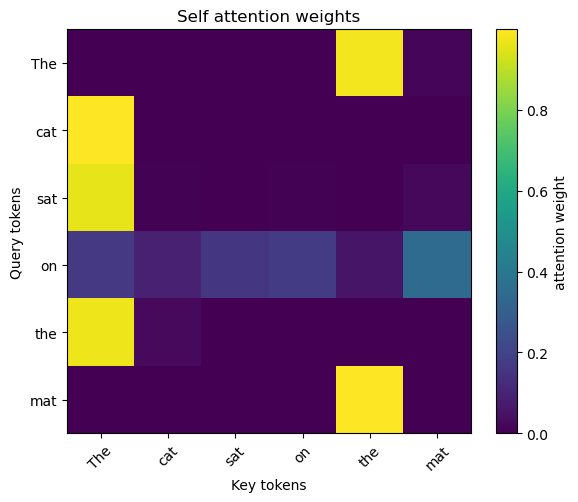

In [31]:
plt.figure(figsize=(6, 5))
plt.imshow(attn_weights, interpolation="nearest")
plt.colorbar(label="attention weight")

plt.xticks(range(len(tokens)), tokens, rotation=45)
plt.yticks(range(len(tokens)), tokens)

plt.xlabel("Key tokens")
plt.ylabel("Query tokens")
plt.title("Self attention weights")
plt.tight_layout()
plt.show()


If this were a trained model, we might see:

- Strong attention along the diagonal (each token attending to itself)
- Interesting off diagonal patterns, such as pronouns attending to their antecedents,
  or verbs attending to their subjects and objects.

Here the patterns are random, but the visualization still communicates the structure of self attention:
every token can interact with every other token.


## 9. Visualizing tokens as points in space

We now want to visualize each token as a point in a Cartesian space.

We already have vector representations for each token:
- `X` is the original embedding of each token
- `attn_output` is the context enriched representation after self attention

Both have shape `(seq_len, d_model)` where `d_model` is 4 in this notebook.

To plot them in a 2D plane we will:
1. Take the matrix of token vectors.
2. Compute a tiny PCA by hand to reduce from `d_model` dimensions to 2.
3. Plot the 2D points and label them with the tokens.

This is not part of the Transformer itself, it is just a visualization tool.

In [32]:
def pca_project(X, n_components=2):
    """
    Simple PCA using NumPy only.
    X has shape (n_samples, n_features).
    Returns X projected to n_components dimensions.
    """
    # Center the data
    X_centered = X - X.mean(axis=0, keepdims=True)
    
    # Covariance matrix
    cov = X_centered.T @ X_centered / (X_centered.shape[0] - 1)
    
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    
    # Sort eigenvectors by decreasing eigenvalue
    idx = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, idx]
    
    # Take the first n_components eigenvectors
    W = eigvecs[:, :n_components]  # shape (d_model, n_components)
    
    # Project
    X_reduced = X_centered @ W     # shape (n_samples, n_components)
    return X_reduced


### 9.1 Plotting the original embeddings

First we visualize the original token embeddings `X`, projected to 2D with PCA.
Each point represents one token in our sentence.


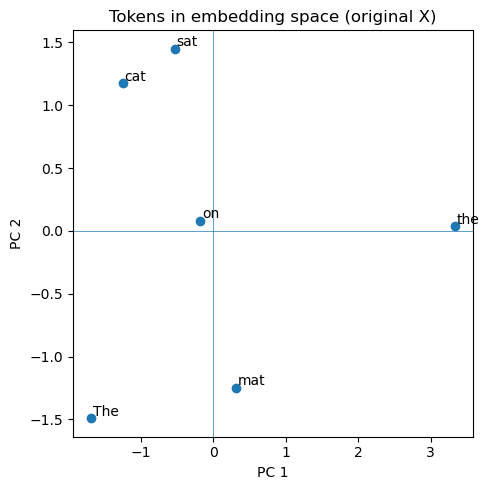

In [33]:
X_2d = pca_project(X, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(X_2d[:, 0], X_2d[:, 1])

for i, token in enumerate(tokens):
    plt.text(X_2d[i, 0] + 0.02, X_2d[i, 1] + 0.02, token)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Tokens in embedding space (original X)")
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.tight_layout()
plt.show()


### 9.2 Plotting the context enriched representations

We can do the same with the attention outputs `attn_output`.
These vectors already mix information from the entire sentence.

Let us project them to 2D with the same PCA procedure.


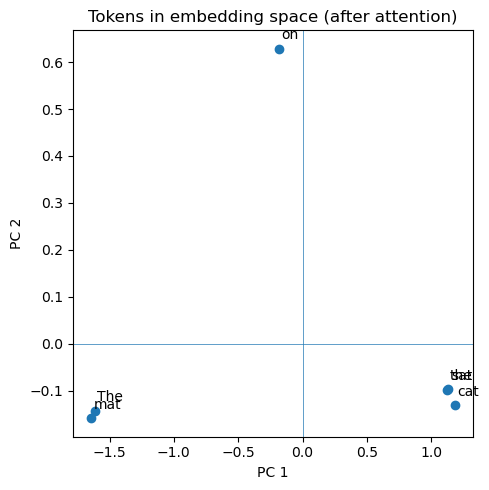

In [34]:
attn_2d = pca_project(attn_output, n_components=2)

plt.figure(figsize=(5, 5))
plt.scatter(attn_2d[:, 0], attn_2d[:, 1])

for i, token in enumerate(tokens):
    plt.text(attn_2d[i, 0] + 0.02, attn_2d[i, 1] + 0.02, token)

plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("Tokens in embedding space (after attention)")
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.tight_layout()
plt.show()


## 3D visualization of token embeddings

We now project the token vectors into 3 dimensions and visualize them in a 3D scatter plot.

First we use the original embeddings `X`.

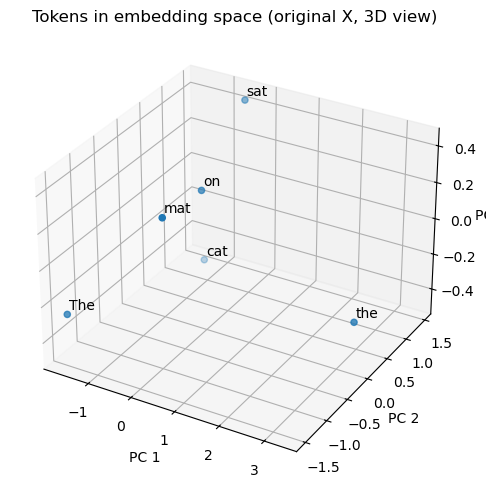

In [35]:
from mpl_toolkits.mplot3d import Axes3D  # sometimes needed for 3D projections

# Project original embeddings to 3D
X_3d = pca_project(X, n_components=3)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2])

for i, token in enumerate(tokens):
    ax.text(
        X_3d[i, 0] + 0.02,
        X_3d[i, 1] + 0.02,
        X_3d[i, 2] + 0.02,
        token
    )

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Tokens in embedding space (original X, 3D view)")

plt.tight_layout()
plt.show()


Next we do the same for the attention outputs `attn_output`.

These vectors already mix information from the entire sentence, so this gives a 3D view of the context aware representations.


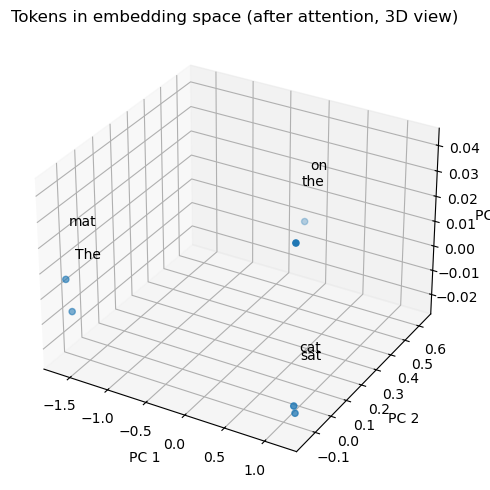

In [36]:
# Project attention outputs to 3D
attn_3d = pca_project(attn_output, n_components=3)

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(attn_3d[:, 0], attn_3d[:, 1], attn_3d[:, 2])

for i, token in enumerate(tokens):
    ax.text(
        attn_3d[i, 0] + 0.02,
        attn_3d[i, 1] + 0.02,
        attn_3d[i, 2] + 0.02,
        token
    )

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("Tokens in embedding space (after attention, 3D view)")

plt.tight_layout()
plt.show()


Even though the parameters are random, these 3D views help build geometric intuition.

Each token is a point in a high dimensional space.
Attention can be seen as a way of reshaping this space by mixing information from other tokens.
In a trained model, similar or related tokens are expected to form meaningful clusters in such visualizations.


## 9. Summary

In this notebook we:

1. Took a simple sentence and **decomposed it into tokens**, assigning each token a position and an id.
2. Created a small **embedding matrix** and mapped token ids to embedding vectors.
3. Defined weight matrices `W_Q`, `W_K` and `W_V` and computed **Q, K and V** for each token.
4. Built a **tiny numeric example** with two tokens to show the attention formula with very simple numbers.
5. For the token `"cat"`:
   - Computed dot product scores with all keys
   - Scaled the scores and applied softmax to get attention weights
   - Used these weights to mix the value vectors into a new representation
6. Generalized the computation to **all tokens at once** using the standard matrix formula:
   \[
   \text{Attention}(Q, K, V) = \text{softmax}\left( \frac{Q K^\top}{\sqrt{d_k}} \right) V
   \]
7. Visualized the attention weights as a **heatmap**, connecting rows and columns to query and key tokens.

Even with random weights, this pipeline shows the core mechanism of self attention:
each token builds a new representation by looking at and combining information from every other token.

### Possible next steps

- Add **positional encodings** so that the model can distinguish between tokens at different positions.
- Implement **multi head attention** by repeating this computation in parallel with different sets of `W_Q, W_K, W_V`.
- Replace random weights with trainable parameters and train on a toy task
  (for example, predicting the next word in tiny synthetic sentences).
